In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import itertools
from collections import OrderedDict
import sky_anisotropy as sa
import numpy as np
import pandas as pd
import xarray as xr
import healpy as hp
import matplotlib.pyplot as plt

from dask.distributed import LocalCluster, Client, progress
from dask.diagnostics import ProgressBar
import dask.array as da
import dask.dataframe as dd
from dask import delayed, compute
from bokeh.io import output_notebook

import comptools as comp

%matplotlib inline

In [4]:
# output_notebook()

In [5]:
# cluster = LocalCluster(n_workers=10,
#                        threads_per_worker=5,
#                        diagnostics_port=8787)
# client = Client(cluster)

In [6]:
# client

In [7]:
nside = 64
npix = hp.nside2npix(nside)

In [8]:
# ddf = dd.read_hdf('/data/user/vwiedemann/hawcdata/hawc_2016-2/datasample_10percent.hdf',
#                   'dataframe',
#                   mode='r',
#                   chunksize=1000000)

ddf = dd.read_hdf('data_dataframe.hdf', 'dataframe', mode='r', chunksize=100000)

In [9]:
ddf

,lap_cos_zenith,log_s125,log_dEdX,lap_ra,lap_dec,reco_log_energy,reco_energy
npartitions=67,,,,,,,
,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [11]:
max_energy = max_energy.persist()  # start computation in the background
progress(max_energy)      # watch progress

VBox()

In [13]:
max_energy.compute()

15.15

In [14]:
min_energy = ddf['protonllhEnergy'].min()
min_energy = min_energy.persist()  # start computation in the background
progress(min_energy)      # watch progress

VBox()

In [16]:
min_energy.compute()

11.65

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


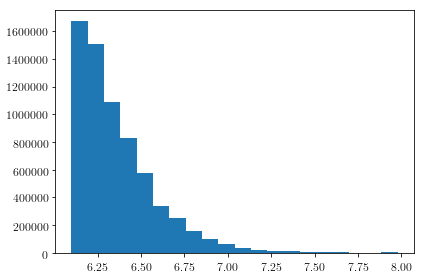

In [10]:
# plt.hist(ddf['protonllhEnergy'].values, bins=20)
plt.hist(ddf['reco_log_energy'].values, bins=20)
plt.show()

In [10]:
energy_bins = np.arange(6.1, 8, 0.1)
energy_bins

array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ])

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


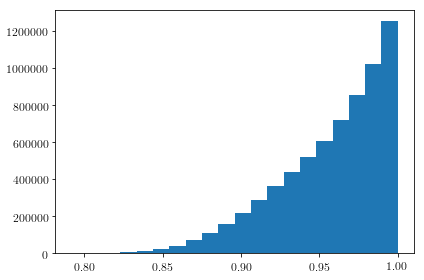

In [111]:
plt.hist(ddf['lap_cos_zenith'].values, bins=20)
plt.show()

In [160]:
# zenith_bins = np.linspace(0.85, 1.0, 10)
zenith_bins = np.linspace(0.85, 1.0, 4)
zenith_bins

array([0.85, 0.9 , 0.95, 1.  ])

In [161]:
col_to_bins = OrderedDict()
# lap_cos_zenith must come before reco_log_energy, but not sure why
col_to_bins['lap_cos_zenith'] = zenith_bins
col_to_bins['reco_log_energy'] = energy_bins

# energy_bins = np.linspace(12, 15, 20)
# col_to_bins = OrderedDict()
# col_to_bins['protonllhEnergy'] = energy_bins

col_to_bins

OrderedDict([('lap_cos_zenith', array([0.85, 0.9 , 0.95, 1.  ])),
             ('reco_log_energy',
              array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
                     7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ]))])

In [162]:
data = sa.binned_skymaps(ddf,
                         col_to_bins=col_to_bins,
                         ra_col='lap_ra',
                         dec_col='lap_dec',
                         nside=nside,
                         num_workers=25)

[########################################] | 100% Completed | 45.4s
[########################################] | 100% Completed |  0.1s


In [163]:
data

<xarray.DataArray (lap_cos_zenith: 3, reco_log_energy: 19, ipix: 49152)>
array([[[   0.,    0., ...,    0.,    0.],
        [   0.,    0., ...,    0.,    0.],
        ...,
        [   0.,    0., ...,    0.,    0.],
        [   0.,    0., ...,    0.,    0.]],

       [[   0.,    0., ...,    0.,    0.],
        [   0.,    0., ...,    0.,    0.],
        ...,
        [   0.,    0., ...,    0.,    0.],
        [   0.,    0., ...,    0.,    0.]],

       [[   0.,    0., ..., 1487., 1502.],
        [   0.,    0., ..., 1223., 1249.],
        ...,
        [   0.,    0., ...,    0.,    2.],
        [   0.,    0., ...,    0.,    0.]]])
Coordinates:
  * lap_cos_zenith   (lap_cos_zenith) float64 0.875 0.925 0.975
  * reco_log_energy  (reco_log_energy) float64 6.15 6.25 6.35 6.45 6.55 6.65 ...
Dimensions without coordinates: ipix

In [164]:
data.shape

(3, 19, 49152)

In [165]:
data.nbytes / 1e6

22.413312

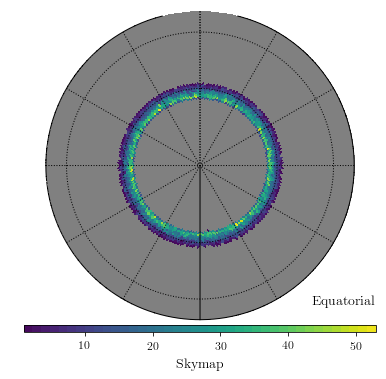

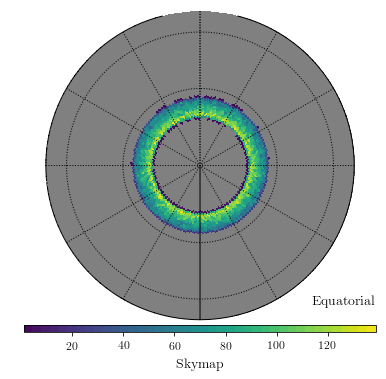

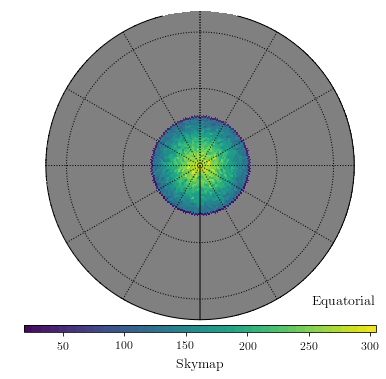

In [167]:
for i in range(len(zenith_bins) - 1):
    m = data[i, 5].copy()
    m[m == 0] = hp.UNSEEN
    comp.plot_skymap(m, polar=True)
    plt.show()

In [168]:
size = np.deg2rad(10)
pix = np.arange(npix)

In [169]:
ra_test = np.deg2rad(0)
dec_test = np.deg2rad(-80)
theta_test, phi_test = sa.equatorial_to_healpy(ra_test, dec_test)
vec_test = hp.ang2vec(theta_test, phi_test)
pix_center = hp.ang2pix(nside, theta_test, phi_test)
pix_center

48732

In [170]:
on_mask = sa.disc_on_region(pix=pix, pix_center=pix_center, size=size, nside=nside)
on_mask

array([False, False, False, ..., False, False,  True])

In [171]:
off_mask = sa.theta_band_off_region(pix=pix, pix_center=pix_center, on_region_mask=on_mask, nside=nside)
off_mask

array([False, False, False, ...,  True,  True, False])

In [172]:
on_mask.sum(), off_mask.sum()

(375, 1137)

In [173]:
data[..., on_mask].sum(axis=-1).values.shape

(3, 19)

In [174]:
data.shape[-1]

49152

In [175]:
def region_hist(data, mask):
    return data[..., mask].sum(axis=-1)

In [176]:
data.shape, on_mask.shape

((3, 19, 49152), (49152,))

In [177]:
on_mask.ndim

1

In [178]:
r = region_hist(data, on_mask)
r

<xarray.DataArray (lap_cos_zenith: 3, reco_log_energy: 19)>
array([[0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.75550e+04, 1.59430e+04, 9.97500e+03, 6.77900e+03, 5.19800e+03,
        3.65400e+03, 1.93800e+03, 1.04500e+03, 9.99000e+02, 3.73000e+02,
        2.36000e+02, 1.56000e+02, 9.00000e+01, 6.60000e+01, 5.30000e+01,
        3.40000e+01, 2.00000e+01, 7.00000e+00, 1.50000e+01],
       [3.69852e+05, 2.97425e+05, 2.38500e+05, 1.26206e+05, 1.02437e+05,
        6.56110e+04, 4.68500e+04, 2.20490e+04, 1.54820e+04, 7.17400e+03,
        5.37400e+03, 2.85800e+03, 2.33600e+03, 1.13800e+03, 9.71000e+02,
        6.18000e+02, 3.51000e+02, 2.59000e+02, 3.30000e+02]])
Coordinates:
  * lap_cos_zenith   (lap_cos_zenith) float64 0.875 0.925 0.975
  * reco_log_energy  (

In [179]:
r.sum(axis=0)

<xarray.DataArray (reco_log_energy: 19)>
array([3.87407e+05, 3.13368e+05, 2.48475e+05, 1.32985e+05, 1.07635e+05,
       6.92650e+04, 4.87880e+04, 2.30940e+04, 1.64810e+04, 7.54700e+03,
       5.61000e+03, 3.01400e+03, 2.42600e+03, 1.20400e+03, 1.02400e+03,
       6.52000e+02, 3.71000e+02, 2.66000e+02, 3.45000e+02])
Coordinates:
  * reco_log_energy  (reco_log_energy) float64 6.15 6.25 6.35 6.45 6.55 6.65 ...

In [180]:
from sky_anisotropy.core import on_off_chi_squared_single

In [181]:
pix_center

48732

In [188]:
data.reco_log_energy > 6.4

<xarray.DataArray 'reco_log_energy' (reco_log_energy: 19)>
array([False, False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])
Coordinates:
  * reco_log_energy  (reco_log_energy) float64 6.15 6.25 6.35 6.45 6.55 6.65 ...

In [192]:
on_off_chi_squared_single(data, pix_center, on_region='disc',
                          size=size, off_region='theta_band',
                          nside=nside, hist_func=lambda x: x.sum(axis=0)[(x.reco_log_energy > 6.4) & (x.reco_log_energy < 7.8)])
#                           nside=nside, hist_func=None)

counts_on = [132985. 107635.  69265.  48788.  23094.  16481.   7547.   5610.   3014.
   2426.   1204.   1024.    652.    371.]
scaled_counts_off = [135427.70386002 108262.97489757  68820.66965876  46898.94081976
  22104.55816971  17165.13801154   7447.92942234   5382.29866113
   3073.65251623   2297.29028584   1280.94090085   1020.89172861
    576.87763975    336.13342788]


{'alpha': 0.37852863500427547,
 'chi2': 233.8719099532314,
 'ndof': 14,
 'num_on': 420096.0,
 'pix_center': 48732,
 'pval': 6.143047694496854e-42,
 'sig': 13.517759460474558}

In [193]:
for col in col_to_bins.keys():
    print('col = {}'.format(col))

col = lap_cos_zenith
col = reco_log_energy


In [49]:
def digitize_columns(partition, col_to_bins):
    for col in col_to_bins.keys():
        bins = col_to_bins[col]
        partition[col + '_digitized'] = np.digitize(partition[col], bins=bins) - 1
    return partition

In [137]:
# meta = ddf.dtypes.to_dict()
# meta['reco_log_energy_digitized'] = np.int64
# meta['lap_cos_zenith_digitized'] = np.int64
# meta

In [54]:
ddf_digitized = ddf.map_partitions(digitize_columns, col_to_bins)
# ddf_digitized = ddf.map_partitions(digitize_columns, col_to_bins, meta=meta)

In [55]:
ddf_digitized

,lap_cos_zenith,log_s125,log_dEdX,lap_ra,lap_dec,reco_log_energy,reco_energy,lap_cos_zenith_digitized,reco_log_energy_digitized
npartitions=67,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [57]:
# def unique_counts(block):
#     idx, counts = np.unique(block, return_counts=True)
#     return idx, counts

In [97]:
shape = list((len(bins)-1 for bins in col_to_bins.values()))
shape

[3, 19]

In [59]:
bin_idxs = [np.arange(l) for l in shape]
bin_idxs

[array([0, 1, 2]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18])]

In [60]:
print(len(list(itertools.product(*bin_idxs))))

57


In [61]:
def ang2pix(theta, phi, nside=64):
    return hp.ang2pix(nside=nside, theta=theta, phi=phi)

In [88]:
cols = col_to_bins.keys()
maps = []
for idx in itertools.product(*bin_idxs):
    bool_masks = list(ddf_digitized['{}_digitized'.format(col)] == i for col, i in zip(cols, idx))
    if len(bool_masks) == 1:
        mask = bool_masks[0]
    else:
        mask = da.logical_and(*bool_masks)
    theta, phi = sa.equatorial_to_healpy(ddf.loc[mask, 'lap_ra'],
                                         ddf.loc[mask, 'lap_dec'])
    ipix = da.map_blocks(ang2pix, theta.values, phi.values)
    m, _ = da.histogram(ipix, bins=np.arange(npix + 1))
    maps.append(m)

In [89]:
maps

[dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,
 dask.array<sum-aggregate, shape=(49152,), dtype=int64, chunksize=(49152,)>,

In [90]:
with ProgressBar():
    maps = compute(*maps, num_worker=25, scheduler='threading')

[########################################] | 100% Completed | 48.1s
[########################################] | 100% Completed |  0.1s


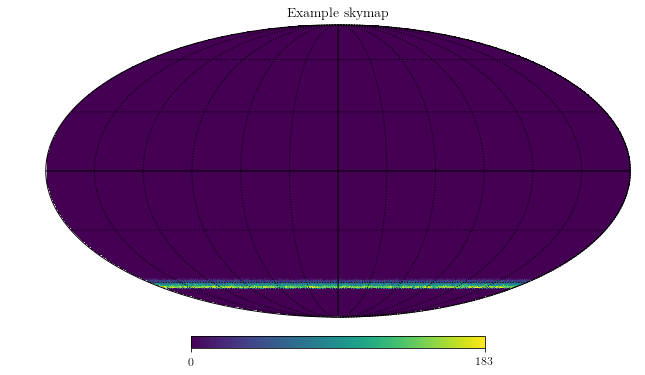

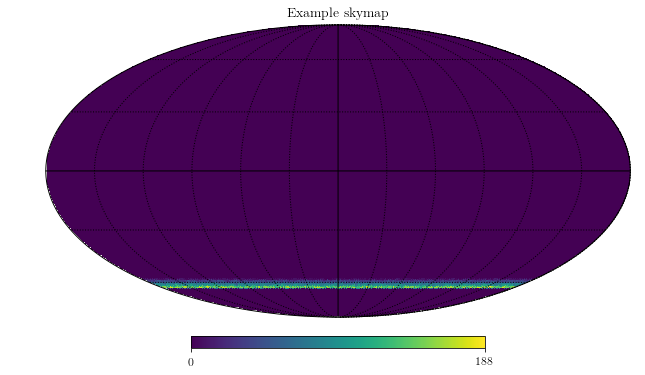

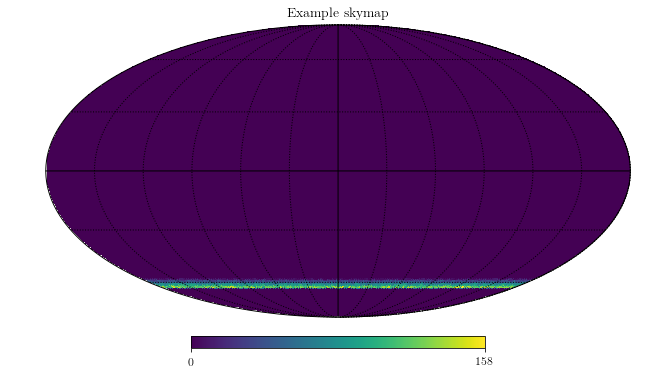

In [91]:
for m in maps[:3]:
    hp.mollview(m, title='Example skymap')
    hp.graticule(verbose=False)
    plt.show()

In [126]:
data = np.zeros(shape + [npix])

In [127]:
for idx, m in zip(itertools.product(*bin_idxs), maps):
    data[idx] = m

In [128]:
data[0, 3].shape

(49152,)

In [133]:
dims = col_to_bins.keys() + ['ipix']
dims

['lap_cos_zenith', 'reco_log_energy', 'ipix']

In [141]:
coords = {}
for col in col_to_bins.keys():
    bins = col_to_bins[col]
    coords[col] = (bins[1:] + bins[:-1]) / 2
coords

{'lap_cos_zenith': array([0.875, 0.925, 0.975]),
 'reco_log_energy': array([6.15, 6.25, 6.35, 6.45, 6.55, 6.65, 6.75, 6.85, 6.95, 7.05, 7.15,
        7.25, 7.35, 7.45, 7.55, 7.65, 7.75, 7.85, 7.95])}

In [142]:
data = xr.DataArray(data, dims=dims, coords=coords)
print(data)

<xarray.DataArray (lap_cos_zenith: 3, reco_log_energy: 19, ipix: 49152)>
array([[[   0.,    0., ...,    0.,    0.],
        [   0.,    0., ...,    0.,    0.],
        ...,
        [   0.,    0., ...,    0.,    0.],
        [   0.,    0., ...,    0.,    0.]],

       [[   0.,    0., ...,    0.,    0.],
        [   0.,    0., ...,    0.,    0.],
        ...,
        [   0.,    0., ...,    0.,    0.],
        [   0.,    0., ...,    0.,    0.]],

       [[   0.,    0., ..., 1487., 1502.],
        [   0.,    0., ..., 1223., 1249.],
        ...,
        [   0.,    0., ...,    0.,    2.],
        [   0.,    0., ...,    0.,    0.]]])
Coordinates:
  * lap_cos_zenith   (lap_cos_zenith) float64 0.875 0.925 0.975
  * reco_log_energy  (reco_log_energy) float64 6.15 6.25 6.35 6.45 6.55 6.65 ...
Dimensions without coordinates: ipix


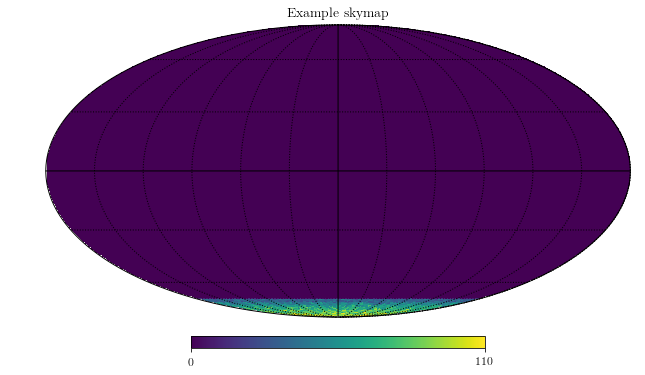

In [144]:
hp.mollview(data[2, 7], title='Example skymap')
hp.graticule(verbose=False)
plt.show()